In [90]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [91]:
%matplotlib inline

In [10]:
with open("heroEncoder", "rb") as f: 
    encoder = pickle.load(f)

In [21]:
df = pd.read_json('final.json')
df['winner'] = df.radiant_win.apply(lambda x: 'Radiant' if x else 'Dire')
df = df.drop(['radiant_win'], axis = 1)

In [22]:
X = df.drop(['winner'], axis = 1).copy()
y = df.winner

In [37]:
labEncoder = LabelEncoder()
labEncoder.fit(y)
y = labEncoder.transform(y)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

In [52]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
     "max_depth"        : [ 3, 4, 5, 6],
     "min_child_weight" : [ 1, 3, 5],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3, verbose = 10)

grid.fit(X_train, Y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.9min
[Parallel(

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'max_depth': [3, 4, 5, 6],

In [53]:
grid.best_params_

{'colsample_bytree': 0.3, 'eta': 0.05, 'max_depth': 6, 'min_child_weight': 3}

In [161]:
param = {
    'eta': 0.05, 
    'max_depth': 6,
    'min_child_weight': 3,
    'colsample_bytree': 0.3,  
    'objective': 'binary:logistic'} 

steps = 1000

In [162]:
model = xgb.train(param, D_train, steps)

In [163]:
preds = model.predict(D_test)

In [164]:
preds

array([0.74957985, 0.28389734, 0.7345327 , ..., 0.72668886, 0.55707157,
       0.5083981 ], dtype=float32)

In [165]:
Y_test

array([1, 0, 1, ..., 0, 1, 0])

In [166]:
fpr, tpr, thresholds = roc_curve(Y_test, preds, pos_label=1)

In [167]:
auc = roc_auc_score(Y_test,preds)

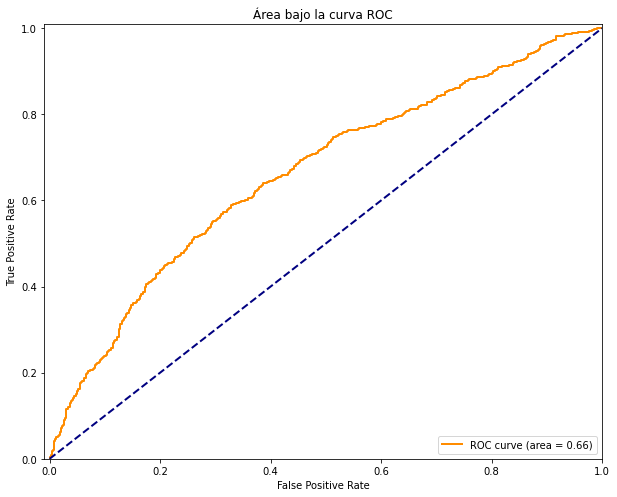

In [168]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Área bajo la curva ROC')
plt.legend(loc="lower right")
plt.show()

In [169]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
cutoff = roc_t['threshold'].values[0]

In [170]:
cutoff

0.52632636

In [171]:
preds

array([0.74957985, 0.28389734, 0.7345327 , ..., 0.72668886, 0.55707157,
       0.5083981 ], dtype=float32)

In [172]:
y_pred = [1 if i >= cutoff else 0 for i in preds]

In [173]:
f1_score(Y_test, y_pred)

0.6162642947903431

In [174]:
precision_score(Y_test, y_pred)

0.610062893081761

In [175]:
recall_score(Y_test, y_pred)

0.6225930680359435

In [176]:
accuracy_score(Y_test, y_pred)

0.6232064878353087

In [177]:
model.save_model('modelo.bin')

In [179]:
bst = xgb.Booster({'nthread':4})
bst.load_model("modelo.bin")

In [180]:
preds1 = bst.predict(D_test)

In [181]:
preds1

array([0.74957985, 0.28389734, 0.7345327 , ..., 0.72668886, 0.55707157,
       0.5083981 ], dtype=float32)

In [182]:
preds

array([0.74957985, 0.28389734, 0.7345327 , ..., 0.72668886, 0.55707157,
       0.5083981 ], dtype=float32)

In [185]:
with open("labelEncoder", "wb") as f: 
    pickle.dump(labEncoder, f)